In [214]:
import pandas as pd
import wikipedia as wp
from pygeocoder import Geocoder
import time
import numpy as np
from googletrans import Translator
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from datetime import date, timedelta

import tweepy; import json
from apikeys import twitterAccessToken as access_token
from apikeys import twitterAccessTokenSecret as access_token_secret
from apikeys import twitterConsumerKey as consumer_key
from apikeys import twitterConsumerSecretKey as consumer_secret

def worldTweets(search_term,numTweets, numDays):
    #-- Get the most populated cities from wikipedia (Thank you wikipedia library!) --
    html = wp.page("List_of_cities_by_population_density").html().encode("UTF-8")
    worldCities = pd.read_html(html)[1]
    worldCities = worldCities.drop([2,3,4],axis=1)
    worldCities = worldCities.rename(columns={0:'city',1:'population',5:'density',6:'country'})
    worldCities = worldCities.iloc[1:]
    worldCities['population'] = [int(city.split('\xa0')[-1].split('[')[0].replace(',','')) for city in worldCities['population']]
    worldCities['density'] = [int(city.split('\xa0')[-1].split('[')[0].replace(',','')) for city in worldCities['density']]
    #--- ---- ----- ----- ---- ---- ----- ---- ---- ----- --- ---- ---- ----- ---- ---
    
    #--- Get tweets by Worlds most densily populated cities ---- --- ---- ---- --- ---
    translator = Translator()
    comparisons=pd.DataFrame(columns=['time density','sentiment'])
    cityCount = 3
    for index,row in worldCities.iterrows():
        #-- location --- ----- --- ----
        city,pop,density,country = row
        cityCountry = city+' , '+country

        #-- language conversion --- ---- --
        languagesDf = getCountryLanguages()
        if translateToLocalLanguage:
            try:
                translatedSearch = translator.translate(search_term, src='en', dest=languagesDf.loc[country,'language']).text
            except ValueError:
                print("could not translate ", languagesDf.loc[country,'language'])
                translatedSearch=search_term
                print('translated word: ',translatedSearch)
        else:
            translatedSearch=search_term
        #--- --- --- ---- ---- --- --- ---
        
        try:
            tweetsWorld = pd.concat([tweetsWorld, SearchForData(translatedSearch, numTweets, cityCountry, 100)], axis=0)
        except:
            tweetsWorld = SearchForData(translatedSearch, numTweets, cityCountry, 100)
        print('\n')
        time.sleep(4)
        #if cityCount==0:
        #    break
        #else:
        #    cityCount-=1
    return tweetsWorld

def usTweets(search_term, numTweets, numDays):
    #--- population per cities in United States --- ---- ---- --- ---- --- --- --- ---
    html = wp.page("List_of_United_States_cities_by_population_density").html().encode("UTF-8")
    UScities = pd.read_html(html)[1]
    UScities = UScities.drop([0,2,4,6,8],axis=1)
    UScities = UScities.rename(columns={1:'city',3:'state',5: 'land area (mi^2)',7:'density'})
    UScities = UScities.iloc[1:]
    #df['population']=[int(city.split('\xa0')[-1].split('[')[0].replace(',','')) for city in df['population']]
    UScities['density'] = [float(city.split('\xa0')[-1].split('[')[0].replace(',','')) for city in UScities['density']]
    UScities['land area (mi^2)']=[float(area.split('\xa0')[-1]) for area in UScities['land area (mi^2)']]
    #--- ---- ----- ----- ---- ---- ----- ---- ---- ----- --- ---- ---- ----- ---- ---
    
    
    
    #--- Add US Cities --- ---- ---- ---- ---- ---
    cityCount = 1
    for index,row in UScities.iterrows():
        #-- location --- ----- --- ----
        city,state,area,density = row
        cityState = state+' , '+city

        try:
            tweetsUS = pd.concat([tweetsUS, SearchForData(search_term=search_term, nTweets=numTweets, cityCountry=cityState,radius=max(area,5), numDays=numDays )], axis=0)
        except:
            tweetsUS = SearchForData(search_term=search_term, nTweets=numTweets, cityCountry=cityState,radius=max(area,5), numDays=numDays)
        
        print('\n')
        time.sleep(4)
        if cityCount==0:
            break
        else:
            cityCount-=1
    return tweetsUS

def parse_url( url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    listylist=[]
    for table in soup.find_all('table'):
        listylist.append(parse_html_table(table))
    return listylist

def parse_html_table( table):
    n_columns = 0; n_rows=0; column_names = []

    # Find number of rows and columns
    # we also find the column titles if we can
    for row in table.find_all('tr'):

        # Determine the number of rows in the table
        td_tags = row.find_all('td')
        if len(td_tags) > 0:
            n_rows+=1
            if n_columns == 0:
                # Set the number of columns for our table
                n_columns = len(td_tags)

        # Handle column names if we find them
        th_tags = row.find_all('th') 
        if len(th_tags) > 0 and len(column_names) == 0:
            for th in th_tags:
                column_names.append(th.get_text())

    # Safeguard on Column Titles
    if len(column_names) > 0 and len(column_names) != n_columns:
        raise Exception("Column titles do not match the number of columns")

    columns = column_names if len(column_names) > 0 else range(0,n_columns)
    df = pd.DataFrame(columns = columns,
                      index= range(0,n_rows))
    row_marker = 0
    for row in table.find_all('tr'):
        column_marker = 0
        columns = row.find_all('td')
        for column in columns:
            df.iat[row_marker,column_marker] = column.get_text()
            column_marker += 1
        if len(columns) > 0:
            row_marker += 1

    # Convert to float if possible
    for col in df:
        try:
            df[col] = df[col].astype(float)
        except ValueError:
            pass

    return df

def getCountryLanguages():
    #TODO: Use the .apply to just change the table to one dialect. Imrpove language scope later.
    df = parse_url('https://www.infoplease.com/world/countries-world/languages-spoken-each-country-world')
    countryLanguages = df[0].rename(columns={0:'country',1:'language'}).set_index('country')
    countryLanguages['language'] = [re.sub('\d+|%|\(.*\)|\s','',i).split(',')[0].split(';')[0] for i in countryLanguages['language']]
    return countryLanguages


#returns hashtag, followers, following, text, geo, date
#cityCountry example: 'paris,france'
def SearchForData(search_term, nTweets, cityCountry='',radius=100, numDays=1):
    
    # Setup Tweepy API Authentication
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())
    
    #--- Calculate geocordinates from cityCountry --- --- ---- ---- --- --- --- --
    geoConvertTries = 0
    while True:
        try:
            result = Geocoder.geocode(cityCountry)
        except Exception as error:
            #print('errrooooorrrrr: ',error.message)
            if 'OVER_QUERY_LIMIT' in str(error):
                print('Encountered an error:{0}\nWaiting 30 seconds and trying again.'.format(error))
                time.sleep(30)
                if geoConvertTries>10:
                    print("Could not convert geo. returning empty list")
                    return []
            elif not (re.search('^\w+,\w+$',cityCountry)):
                print("cityCountry input format is incorrect. It should be \'city,Country\' like \'paris,france\'")
                return []
            else:
                print("Could not convert geo. returning empty list")
                return []
        else:
            break
        geoConvertTries+=1
    # 34.0934,56.134,50mi
    coords = str(result[0].coordinates).replace('(','').replace(')','') + f',{radius}mi'
    coords=coords.replace(' ','')
    print(cityCountry, ": ", coords)
    #--- ---- ----- ---- ---- ---- ---- ---- --- ---- ---- --- ---- --- ---- --- --

    #--- grab tweets --- ---- ---- ---- ---- ---- ---- ---- --- --- ---- ---- ----
    maxTweets = 10000; oldest_tweet = None; unique_ids = []; desiredTweets = [];nTweetsPerDay=nTweets/numDays
    for day,num in zip([str(date.today() - timedelta(i)).split()[0] for i in range(numDays)], range(1,numDays+1)):
        tweetsPerDay=[];tries=1
        while len(desiredTweets) < min(nTweetsPerDay*num , maxTweets/numDays):
            
            #--- determine whether to grab tweets by geo or not --- ---- --- ----- --
            while True:
                try:
                    if cityCountry:
                        tweetsPerDay = api.search(search_term, count=nTweetsPerDay, result_type="recent", max_id=oldest_tweet, geocode=coords, until=day)
                    else:
                        tweetsPerDay = api.search(search_term, count=nTweetsPerDay, result_type="recent", max_id=oldest_tweet, until=day)
                    time.sleep(2)
                except Exception as error:
                    print(error[0]['message'],'Trying again after 1 minute.')
                    time.sleep(60)
                else:
                    break
            
            #---- ----- ----- ---- ----- ---- ----- ---- ----- ---- ---- ---- ---- --

            #--- Dont go through an infinite loop trying to fill tweets that don't exist -----
            if len(tweetsPerDay['statuses'])==0:
                print(f'No tweets returned while searching for \'{search_term}\'',len(desiredTweets)\
                     ,' ',day)
                if desiredTweets==[]:
                    return [{'text':None, 'vader':None,
                                          'location':cityCountry, 'geo':coords,
                                          'hashtags':None, 'followers':None,
                                         'friends_count':None,'statuses_count':None,
                                          'created_at':None}]
                return pd.DataFrame(desiredTweets)

            #--- Append relevent tweets to output listy list ---- --- ---- ---- ---- --- ---
            for tweet in tweetsPerDay['statuses']:
                # Append tweet_id to ids list if it doesn't already exist. This allows checking for duplicate tweets
                if tweet["id"] not in unique_ids :
                    unique_ids.append(tweet['id'])
                    if coords:
                        desiredTweets.append({'text':tweet['text'], 'vader':analyzer.polarity_scores(tweet['text'])['compound'],
                                          'location':cityCountry, 'geo':coords,
                                          'hashtags':tweet['entities']['hashtags'], 'followers':tweet['user']['followers_count'],
                                         'friends_count':tweet['user']['friends_count'],'statuses_count':tweet['user']['statuses_count'],
                                          'created_at':datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S %z %Y')})
                    else:
                        desiredTweets.append({'text':tweet['text'], 'vader':analyzer.polarity_scores(tweet['text'])['compound'],
                                          'hashtags':tweet['entities']['hashtags'], 'followers':tweet['user']['followers_count'],
                                         'friends_count':tweet['user']['friends_count'],'statuses_count':tweet['user']['statuses_count'],
                                          'created_at':datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S %z %Y')})
                
                # Reassign the the oldest tweet (i.e. the max_id) subtract 1 so the previous oldest isn't included
                oldest_tweet = tweet["id"] - 1
            print(f'{day}, {cityCountry}: attempt {tries}, {len(desiredTweets)} tweets gathered.');tries+=1

    #--- Print sample tweet --- --- ---- ---- --- ---- ---- --- ---- ---- ---
    translator = Translator()
    try:
        print ('Sample Tweet:',translator.translate(desiredTweets[0]['text'], dest='en').text)
    except:
        print('there was an error translating sample tweet: ',desiredTweets[0]['text'])
    return pd.DataFrame(desiredTweets)


def GetTweetsByPopularCities(search_term, numTweets, translateToLocalLanguage = True, numDays = 1):
    #tweetsWorld = worldTweets()
    tweetsUS = usTweets(search_term, numTweets, numDays)
    tweetsUS['day']=[time.date() for time in tweetsUS['created_at']]
    
    #Calculate time density of tweets per city
    cityData = tweetsUS.groupby(['location','day']).mean()
    aveTimes={}
    for date in tweetsUS.groupby(['location','day'])['created_at']:
        #print (date[0])
        #return
        cityTime, timeseries = date
        (cityState,timeobj)=cityTime
        #print(cit)
        [state,city]=cityState.split(',')
        city=city.lstrip().rstrip(); state=state.rstrip().lstrip()
        cityDensity=UScities.loc[UScities['city']==city].loc[UScities['state']==state].loc[:,'density'].values[0]
        #return timeseries
        try:
            aveTimes[cityTime]=np.mean([(b-a).seconds*10000/cityDensity for a,b in zip(timeseries.tolist()[1:],timeseries.tolist()[0:-1])])
        except:
            if len(timeseries.tolist())<2:
                aveTimes[cityTime]=0
        #print(f'{city}, {cityDensity}, {aveTimes[cityState]}')
    #KeyError: ('New Jersey , Guttenberg', datetime.date(2018, 6, 30))
    cityData['time between tweets']=[aveTimes[citytime] for citytime in cityData.index]
    cityData
    return cityData



cityDataMain = GetTweetsByPopularCities(search_term='spacex', numTweets=50,translateToLocalLanguage= False, numDays = 2)
cityDataMain
#print(tweetsUS.groupby('location').mean())
#print(tweetsWorld.groupby('location').mean())


                                                               #locations are not required inputs
#tweets = SearchForData(search_term='baguettes', nTweets=100, cityCountry='paris,france',radius=100)
#tweets

New Jersey , Guttenberg :  40.7920454,-74.0037505,5mi
2018-07-02, New Jersey , Guttenberg: attempt 1, 25 tweets gathered.
2018-07-01, New Jersey , Guttenberg: attempt 1, 50 tweets gathered.
Sample Tweet: @Gerritzen @SpaceX @FortniteGame Haha thanks.


New Jersey , Union City :  40.7795455,-74.02375119999999,5mi
2018-07-02, New Jersey , Union City: attempt 1, 25 tweets gathered.
2018-07-01, New Jersey , Union City: attempt 1, 50 tweets gathered.
Sample Tweet: @Gerritzen @SpaceX @FortniteGame Haha thanks.




followers  friends_count  statuses_count  \
location                day                                                    
New Jersey , Guttenberg 2018-06-30     777.68         1022.0        27576.80   
                        2018-07-01   16884.20         1257.2        23352.64   
New Jersey , Union City 2018-06-30     777.68         1022.0        27576.84   
                        2018-07-01   16884.20         1257.2        23352.64   

                                       vader  average times  
location                day                                  
New Jersey , Guttenberg 2018-06-30  0.024932     117.356199  
                        2018-07-01  0.113980     231.466081  
New Jersey , Union City 2018-06-30  0.024932     129.374710  
                        2018-07-01  0.113980     255.170646

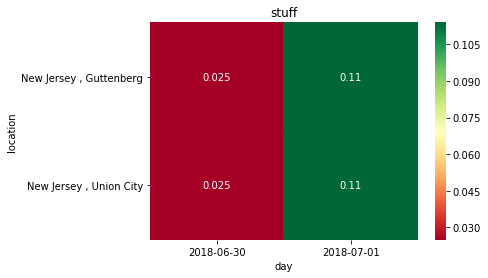

In [216]:
import matplotlib.pyplot as plt
from seaborn import heatmap
#c_matrix = pd.pivot_table(news_data_new, "score", index=["name"], columns=["year_month"], aggfunc=np.mean)                          
matrix=pd.pivot_table(cityDataMain,'vader',index=['location'],columns=['day'],aggfunc=np.mean)
hm = heatmap(matrix, cmap='RdYlGn', annot=True)
hm.set_title('stuff')
plt.savefig('fig.png',dpi=100)
plt.show()

In [151]:
#--- population per cities in United States --- ---- ---- --- ---- --- --- --- ---
html = wp.page("List_of_United_States_cities_by_population_density").html().encode("UTF-8")
UScities = pd.read_html(html)[1]
UScities = UScities.drop([0,2,4,6,8],axis=1)
UScities = UScities.rename(columns={1:'city',3:'state',5: 'land area (mi^2)',7:'density'})
UScities = UScities.iloc[1:]
#df['population']=[int(city.split('\xa0')[-1].split('[')[0].replace(',','')) for city in df['population']]
UScities['density'] = [float(city.split('\xa0')[-1].split('[')[0].replace(',','')) for city in UScities['density']]
UScities['land area (mi^2)']=[float(area.split('\xa0')[-1]) for area in UScities['land area (mi^2)']]
#--- ---- ----- ----- ---- ---- ----- ---- ---- ----- --- ---- ---- ----- ---- ---
city=UScities.loc[UScities['city']=='Guttenberg'].loc[UScities['state']=='New Jersey'].loc[:,'density'].values[0]

import numpy as np
cityData = tweetsUS.groupby('location').mean()
#print(cityData)
aveTimes={}
for date in tweetsUS.groupby('location')['created_at']:
    cityState, timeseries = date
    re.sub('\W','', cityState)
    [state,city]=cityState.split(',')
    city=city.lstrip().rstrip(); state=state.rstrip().lstrip()
    #print(city, state)
    #print('this line: ',UScities.loc[UScities['city']==city])
    cityDensity=UScities.loc[UScities['city']==city].loc[UScities['state']==state].loc[:,'density'].values[0]
    aveTimes[cityState]=np.mean([(b-a).seconds*10000/cityDensity for a,b in zip(timeseries.tolist()[1:],timeseries.tolist()[0:-1])])
    #print(f'{city}, {cityDensity}, {aveTimes[cityState]}')
cityData['average times']=[aveTimes[city] for city in cityData.index]
cityData

,followers,friends_count,statuses_count,vader,average times
location,,,,,
"California , Albany",12664.475000,2494.085000,41845.640000,-0.258858,2931.362055
"California , Alhambra",1807.570000,2007.625000,36424.005000,0.005641,2699.818191
"California , Artesia",1704.073892,1966.793103,24957.950739,-0.008311,2985.501343
"California , Baldwin Park",1406.316038,1314.174528,28348.037736,-0.005242,2573.503197
"California , Bell",12797.990521,13001.018957,70891.734597,-0.126618,2017.529214
"California , Bell Gardens",3089.039409,1426.871921,26007.197044,-0.085866,1843.151112
"California , Bellflower",1451.950355,1787.907801,19833.773050,-0.000277,2529.536833
"California , Berkeley",12640.465000,2150.355000,41316.020000,-0.067293,2826.648354
"California , Cudahy",1064.834906,1354.113208,21860.179245,-0.039462,1423.611557


IndexError: Inconsistent shape between the condition and the input (got (133, 1) and (133,))

In [176]:
numDays=1
for a,b in zip([str(date.today() - timedelta(i)).split()[0] for i in range(numDays)], range(1,numDays+1)):
    print(a,b)

2018-07-02 1


In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
timeBetween=[]
prevCreatedAt = datetime.strptime(tweets[0]['created_at'],'%a %b %d %H:%M:%S %z %Y')
for tweet in tweets[1:]:
    #print(tweet['created_at'])
    timeBetween.append((prevCreatedAt - datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S %z %Y')).total_seconds()/60)
    prevCreatedAt = datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S %z %Y')
plt.plot(range(999),timeBetween)
plt.show()
plt.plot([datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S %z %Y') for tweet in tweets][::-1],range(1000))
#plt.x('date',rotation='vertical')
plt.show()
print((datetime.strptime(tweets[-1]['created_at'],'%a %b %d %H:%M:%S %z %Y')-datetime.strptime(tweets[0]['created_at'],'%a %b %d %H:%M:%S %z %Y')).total_seconds()//60//60)

In [ ]:
#This code came from the following link:
#https://srome.github.io/Parsing-HTML-Tables-in-Python-with-BeautifulSoup-and-pandas/
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re

class HTMLTableParser():

    def parse_url(self, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        listylist=[]
        for table in soup.find_all('table'):
            listylist.append(self.parse_html_table(table))
        return listylist

    def parse_html_table(self, table):
        n_columns = 0; n_rows=0; column_names = []

        # Find number of rows and columns
        # we also find the column titles if we can
        for row in table.find_all('tr'):

            # Determine the number of rows in the table
            td_tags = row.find_all('td')
            if len(td_tags) > 0:
                n_rows+=1
                if n_columns == 0:
                    # Set the number of columns for our table
                    n_columns = len(td_tags)

            # Handle column names if we find them
            th_tags = row.find_all('th') 
            if len(th_tags) > 0 and len(column_names) == 0:
                for th in th_tags:
                    column_names.append(th.get_text())

        # Safeguard on Column Titles
        if len(column_names) > 0 and len(column_names) != n_columns:
            raise Exception("Column titles do not match the number of columns")

        columns = column_names if len(column_names) > 0 else range(0,n_columns)
        df = pd.DataFrame(columns = columns,
                          index= range(0,n_rows))
        row_marker = 0
        for row in table.find_all('tr'):
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                df.iat[row_marker,column_marker] = column.get_text()
                column_marker += 1
            if len(columns) > 0:
                row_marker += 1

        # Convert to float if possible
        for col in df:
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                pass

        return df

#TODO: Use the .apply to just change the table to one dialect. Imrpove language scope later.
obj = HTMLTableParser()
df = obj.parse_url('https://www.infoplease.com/world/countries-world/languages-spoken-each-country-world')
countryLanguages = df[0].rename(columns={0:'country',1:'language'}).set_index('country')
newDict = []
for index, row in countryLanguages.iterrows():
    language = re.sub('\d+|%|\(.*\)|\s','',countryLanguages.loc[index].values[0]).split(',')[0].split(';')[0]
    newDict.append([index, language]) #print(index,": ",language)
newDict

newDf = pd.DataFrame(newDict)
newDf = newDf.rename(columns={0:'country',1:'language'}).set_index('country')
newDf

In [18]:
df = parse_url('https://www.infoplease.com/world/countries-world/languages-spoken-each-country-world')
countryLanguages = df[0].rename(columns={0:'country',1:'language'}).set_index('country')
countryLanguages['languages'] = [re.sub('\d+|%|\(.*\)|\s','',i).split(',')[0].split(';')[0] for i in countryLanguages['language']]
countryLanguages    

,language,languages
country,,
Afghanistan,"Dari Persian, Pashtu (both official), other Tu...",DariPersian
Albania,"Albanian (Tosk is the official dialect), Greek",Albanian
Algeria,"Arabic (official), French, Berber dialects",Arabic
Andorra,"Catalán (official), French, Castilian, Portuguese",Catalán
Angola,"Portuguese (official), Bantu and other African...",Portuguese
Antigua and Barbuda,"English (official), local dialects",English
Argentina,"Spanish (official), English, Italian, German, ...",Spanish
Armenia,"Armenian 98%, Yezidi, Russian",Armenian
Australia,"English 79%, native and other languages",English


In [ ]:
translator=Translator()
translator.translate('Hola me llamo Jennifer 😜😜', dest='en').text

In [37]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())
tweets = api.search('dalailama')
tweets['statuses'][0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Sat Jun 30 19:33:55 +0000 2018',
 'entities': {'hashtags': [{'indices': [87, 93], 'text': 'Tibet'},
   {'indices': [94, 103], 'text': 'Tibetans'},
   {'indices': [104, 114], 'text': 'FreeTibet'}],
  'symbols': [],
  'urls': [{'display_url': 'shar.es/anBniE',
    'expanded_url': 'https://shar.es/anBniE',
    'indices': [47, 70],
    'url': 'https://t.co/zAKFBK5Mna'},
   {'display_url': 'twitter.com/i/web/status/1…',
    'expanded_url': 'https://twitter.com/i/web/status/1013143614623440896',
    'indices': [116, 139],
    'url': 'https://t.co/9GU9LWHwGp'}],
  'user_mentions': [{'id': 23065876,
    'id_str': '23065876',
    'indices': [75, 85],
    'name': 'Tsem Tulku Rinpoche',
    'screen_name': 'tsemtulku'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 1013143614623440896,
 'id_str': '1013143614623440896',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None

In [34]:
import pandas as pd
import wikipedia as wp
from pygeocoder import Geocoder
import time
import re
    
#-- Get the most populated cities from wikipedia (Thank you wikipedia library!) --
html = wp.page("List_of_cities_by_population_density").html().encode("UTF-8")
df = pd.read_html(html)[1]
df=df.drop([2,3,4],axis=1)
df=df.rename(columns={0:'city',1:'population',5:'density',6:'country'})
df=df.iloc[1:]
df['population']=[int(city.split('\xa0')[-1].split('[')[0].replace(',','')) for city in df['population']]
df['density']=[int(city.split('\xa0')[-1].split('[')[0].replace(',','')) for city in df['density']]
df
#--- ---- ----- ----- ---- ---- ----- ---- ---- ----- --- ---- ---- ----- ---- ---

,city,population,density,country
1,Manila,1780148,107561,Philippines
2,Ebeye,15000,107143,Marshall Islands
3,Pateros (Municipality),64147,79114,Philippines
4,Mumbai,12478447,73837,India
5,Dhaka,8523137,73583,Bangladesh
6,Bnei Brak,200162,73159,Israel
7,Caloocan,1489040,72302,Philippines
8,Levallois-Perret,63436,68458,France
9,Le PrÃ©-Saint-Gervais,18121,67047,France
10,Chennai,4681087,66961,India


In [30]:
[int(city.split('\xa0')[-1].split('[')[0].replace(',','')) for city in df['population']]

[1780148,
 15000,
 64147,
 12478447,
 8523137,
 200162,
 1489040,
 63436,
 18121,
 4681087,
 48689,
 22627,
 291972,
 4486679,
 27548,
 1183000,
 1683589,
 27084,
 48410,
 133412,
 353337,
 11481,
 669773,
 2265886,
 43756,
 643100,
 100050,
 73090,
 1072161,
 392869,
 121430,
 323257,
 252171,
 66455,
 11742120,
 529039,
 49708,
 46931,
 3075478,
 36950,
 113085,
 2936116]

In [4]:
tweets['Manila,Philippines']

,followers,following,geo,hashtags,statuses_count,text
0,154060,False,None,[],22455,@ryapee Hi Rya order ako ulit polyblender mejo...
1,83,False,None,[],3030,Yung dating saling pusa naging aso bigla // 🎶
2,643,False,None,"[{'text': 'AdoptDontShop', 'indices': [38, 52]}]",8529,sana meron din dito sa Pilipinas yung #AdoptDo...
3,2729,False,None,[],28771,"Aso nga kasi ako, bantay ako dito hahaha 😂"
4,25,False,None,[],14,lakas mangahol ng kaklase ko dinaig pa aso nam...
5,116,False,None,[],1993,@LampanoElla Dun sa aso oo HAHA
6,113,False,None,[],4495,Me: labas mo dila para lumabas dila ng aso \nS...
7,130,False,None,[],1745,cute kong aso https://t.co/twDprm7o5P
8,54,False,None,[],727,me: pabili pong dog food\ntindero: alin? ung p...
9,24,False,None,[],296,@dsgalarpez hahahaha aso ka na ba ngayon?


In [14]:


# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())
tweetsa=api.search(q='trump', geocode='52.132633,5.29126,100km')
tweetsa['statuses'][0]['user']['location']

'Delft, Holland'

In [114]:
df=pd.DataFrame({'a':1,'b':2,'c':3})
df2=pd.DataFrame({'a':1,'b':2,'c':3})
df+=df2

ValueError: If using all scalar values, you must pass an index

In [82]:
from datetime import date, timedelta
date.today() - timedelta(0)
for day in [str(date.today() - timedelta(i)).split()[0] for i in range(70)]:
    tweets=api.search('cat',geocode = '34.0934,56.134,200mi', until=day, max_id='1012848185839058950')
    print(tweets['statuses'][0]['created_at'])

Fri Jun 29 20:43:37 +0000 2018
Thu Jun 28 14:21:15 +0000 2018
Wed Jun 27 23:51:55 +0000 2018
Tue Jun 26 23:12:07 +0000 2018
Mon Jun 25 19:23:04 +0000 2018
Sun Jun 24 23:58:25 +0000 2018
Sat Jun 23 23:06:10 +0000 2018
Fri Jun 22 17:51:26 +0000 2018
Thu Jun 21 22:46:17 +0000 2018


IndexError: list index out of range

In [95]:
for a,b in zip([1,2],[2,3]):
    print(a,b)


1 2
2 3


In [122]:
#-- Get the most populated cities from wikipedia (Thank you wikipedia library!) --
html = wp.page("List_of_United_States_cities_by_population_density").html().encode("UTF-8")
df = pd.read_html(html)[1]
df=df.drop([0,1,4,5,6,8],axis=1)
df=df.rename(columns={2:'state',3:'city',7:'density'})
df=df.iloc[1:]
#df['population']=[int(city.split('\xa0')[-1].split('[')[0].replace(',','')) for city in df['population']]
df['density']=[int(city.split('\xa0')[-1].split('[')[0].replace(',','').split('.')[0]) for city in df['density']]
df
    #--- ---- ----- ----- ---- ---- ----- ---- ---- ----- --- ---- ---- ----- ---- ---

,state,city,density
1,New York City,New Jersey,57116
2,New York City,New Jersey,51810
3,New York City,New Jersey,49362
4,New York City,New Jersey,39066
5,New York City,New York,27788
6,New York City,New York,27016
7,New York City,New Jersey,24577
8,New York City,New Jersey,24060
9,Los Angeles,California,23216
10,New York City,New Jersey,22437
